In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))

In [3]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

from matplotlib import pyplot as plt
%matplotlib inline

In [23]:
import networkx as nx
import numpy as np

def generate_butterfly_graph(with_weights=True):
    # Generate a graph of 5 nodes
    n = 5
    graph = nx.Graph()
    graph.add_nodes_from(np.arange(0, n, 1))
    if with_weights:
        elist = [(0, 1, 9), (0, 2, 6), (1, 2, 9), (2, 3, 10), (2, 4, 7), (3, 4, 7)]
    else:
        elist = [(0, 1, 1), (0, 2, 1), (1, 2, 1), (2, 3, 1), (2, 4, 1), (3, 4, 1)]
    graph.add_weighted_edges_from(elist)
    return graph

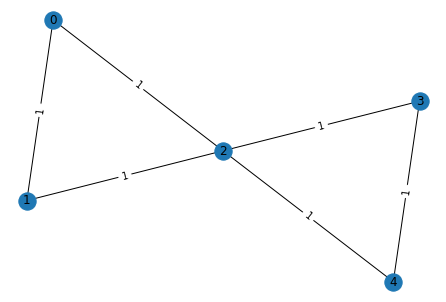

In [24]:
graph = generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
print(graph.name)
max_cut.draw()

In [25]:
step_size = 0.06
a_gamma = np.arange(-np.pi, np.pi, step_size)
b_beta = np.arange(-np.pi, np.pi, step_size)

In [26]:
len(a_gamma) 

105

In [27]:
a_gamma, b_beta = np.meshgrid(a_gamma, b_beta)

In [28]:
quantum_instance = QuantumInstance(
                    backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    shots=SHOTS)
qaoa = QAOA(
            optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=1
            )

op, offset = max_cut_qubo.to_ising()

In [29]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i,j,w in graph.edges.data('weight'):
        if x[i] != x[j]:
            obj -= w
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [30]:
def create_cirucit(beta,gamma):
    circuits = qaoa.construct_circuit([beta,gamma], operator=op)
    circuit = circuits[0]
    circuit.measure_all()
    return circuit

In [31]:
landscape = np.zeros(a_gamma.shape)

for i in range(0, len(landscape)):
    circuits = []
    for j in range(0, len(landscape)):
        # create circuits for entire row 
        circuit = create_cirucit(b_beta[i][j], a_gamma[i][j])
        circuits.append(circuit)
    
    # create one job with circuits 
    job_name = f"{graph.name}_row_{i}"
    job = qiskit.execute(circuits, backend=Aer.get_backend('qasm_simulator'), shots=1024)
    #job.update_name(job_name)
    #print(job_name)
    print(".", end="")
    
    # add results to landscape 
    j = 0
    for count in job.result().get_counts():
        mean = compute_expectation(count, graph)
        landscape[i,j] = mean
        j += 1


.........................................................................................................

[[-3.02734375 -2.93554688 -2.88085938 ... -3.02539062 -2.984375
  -2.99609375]
 [-3.08007812 -2.94921875 -2.92382812 ... -3.1484375  -3.1015625
  -3.015625  ]
 [-2.98046875 -2.8828125  -2.87109375 ... -3.2265625  -3.20507812
  -3.0390625 ]
 ...
 [-3.04101562 -3.11132812 -3.17578125 ... -2.71679688 -2.828125
  -2.93164062]
 [-2.953125   -3.078125   -3.11328125 ... -2.7734375  -2.85546875
  -2.921875  ]
 [-2.95898438 -3.01953125 -3.11328125 ... -2.92578125 -2.98632812
  -2.96679688]]


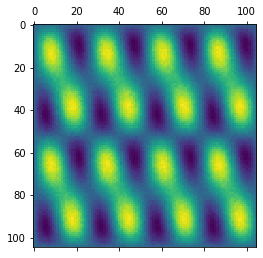

In [32]:
print(landscape)
plt.matshow(landscape)
plt.show()

In [33]:
# Mean of landscape
np.mean(landscape)

-2.6267594954648525

In [34]:
# Minimium 
np.min(landscape)

-3.95703125

In [35]:
# Display Coordinates of Minimum 
np.unravel_index(np.argmin(landscape), landscape.shape)

(43, 5)

In [36]:
# Gamma and beta value of Minimium
gamma, beta = np.unravel_index(np.argmin(landscape), landscape.shape)
opt_gamma = gamma * step_size
opt_beta = beta * step_size
print(f"Opt.Gamma: {opt_gamma}, Opt.Beta: {opt_beta}")

Opt.Gamma: 2.58, Opt.Beta: 0.3


In [37]:
# Save result matrix 
#with open('landscape_toronto_butterfly_weights_results.npy', 'wb') as f:
#    np.save(f, landscape)

In [38]:
import plotly.graph_objects as go

In [39]:
# Plot landscape in 3D 
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)
fig = go.Figure(data=go.Surface(z=landscape, x=a_gamma, y=b_beta))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


fig.update_layout(title="QAOA MaxCut", scene=dict(
    xaxis_title="gamma",
    yaxis_title="beta",
    zaxis_title="mean"
))

In [40]:
# Plot Heatmap 
fig = go.Figure(data=go.Heatmap(z=landscape, x=b_beta, y=a_gamma, type = 'heatmap', colorscale = 'viridis'))

# Update Layout
fig.update_layout(title="QAOA MaxCut", width=700, height=700, xaxis_title="beta", yaxis_title="gamma")

# Display Global Minimium 
fig.add_trace(
    go.Scatter(mode="markers", x=[opt_beta], y=[opt_gamma], marker_symbol=[204], text = [landscape[gamma,beta]],
                   marker_color="red",  hovertemplate="x: %{x}<br>y: %{y}<br> z: %{text:.2f}<extra></extra>", 
                   marker_line_width=1, marker_size=16))

In [ ]:
# Display Optimizer Results

# Display path 
#fig.add_trace(
#    go.Scatter(mode="lines", x=gammas, y=betas, marker_symbol=[200],
#                   marker_color="white", marker_line_width=1, marker_size=8)
#)

# Display start point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[0]], y=[betas[0]], marker_symbol=[204],
#                   marker_color="gray", 
#                   marker_line_width=1, marker_size=16))

# Display end point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[-1]], y=[betas[-1]], marker_symbol=[204],
#                   marker_color="green", 
#                   marker_line_width=1, marker_size=16))



In [ ]:
# Plot Optimizer History
#fig = go.Figure(data=go.Scatter(x=counts, y=values))
#fig.update_layout(xaxis_title="Evaluation Counts", yaxis_title="Evaluated Mean", title="Optimizer")
#fig.show()